# UCM spike train delays

Here we perform model selection over different basis expansions in the UCM evaluated on real neural data.

```
python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-8 --x_mode hd --delays -5 -4 -3 -2 -1 0 1 2 3 4 5 --lr 1e-2 --jitter 1e-5 --gpu 0

python3 models.py --data_type th1 --checkpoint_dir ./checkpoint/ --data_path ../data/ --cv_folds 10 --cv -1 1 2 3 5 6 8 --seeds 123 1234 12345 --batch_size 10000 --max_epochs 3000 --bin_size 40 --likelihood U-el-3 --mapping svgp-64 --x_mode hd-omega-speed-x-y-time --delays -3 -2 -1 0 1 2 3 --lr 1e-2 --jitter 1e-5 --gpu 0
```

### Table of contents

1. [**Synthetic population**](#synthetic)
3. [**SNN**](#snn)
4. [**RNN**](#rnn)

In [1]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import scipy.special as sps
import scipy.stats as scstats
import numpy as np

import sys
sys.path.append("..") # access to library
sys.path.append("../scripts/") # access to scripts
    

import neuroprob as nprb
from neuroprob import utils


device = nprb.inference.get_device(gpu=0)

import models
#import ucm_stats

import pickle


PyTorch version: 1.13.1+cu117
Using device: cuda:0


<a id='simple'></a>
## 1. Loading data

In [3]:
data_path = '../data/'
data_type = 'th1'
bin_size = 40

dataset_dict = models.get_dataset(data_type, bin_size, data_path)

<a id='simple'></a>
## 2. Simple Poisson-histogram model

In [ ]:
unit_used = [40, 24, 35, 81, 26, 42, 27, 41, 20, 29]
units_used = len(unit_used)
bins_hd = 60
bin_hd = np.linspace(0, 2*np.pi+1e-3, bins_hd+1)

shifts = 101
offset = -50
lag_time = np.arange(offset*10, (offset+shifts)*10, 10)

NLL, CVs = neural_utils.temporal_shift(tbin, lag_time, (rhd_t,), (bin_hd,), \
                                       [r_t_spike[u] for u in unit_used], 'cpu')

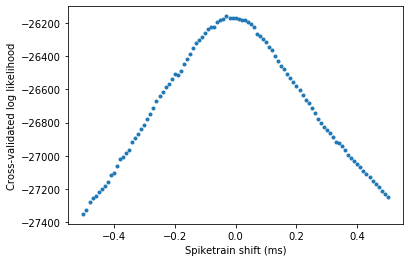

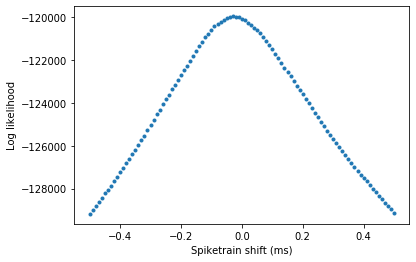

In [25]:
neuron = 9

plt.figure()
#for k in range(5):
#    plt.plot(lag_time*tbin, -CVs[:, k, neuron], linestyle='', marker='.')
plt.plot(lag_time*tbin, -CVs[:, :, neuron].mean(1), linestyle='', marker='.')
plt.xlabel('Spiketrain shift (ms)')
plt.ylabel('Cross-validated log likelihood')
plt.show()

plt.figure()
plt.plot(lag_time*tbin, -NLL[:, neuron], linestyle='', marker='.')
plt.xlabel('Spiketrain shift (ms)')
plt.ylabel('Log likelihood')
plt.show()

In [ ]:
# binning of covariates and analysis
bins_hd = 60
bin_hd = np.linspace(0, 2 * np.pi + 1e-3, bins_hd + 1)
(
    hd_rate,
    hd_occup_time,
    hd_tot_spikes,
) = utils.neural.occupancy_normalized_histogram(
    tbin, 0.0, (rhd_t,), (bin_hd,), spiketimes=r_t_spike
)
hd_prob = hd_occup_time / hd_occup_time.sum()
hd_MI = utils.neural.spike_var_MI(hd_rate, hd_prob)
filter_win = 41
centre_win = filter_win // 2
sigma = 6
sfilter = np.exp(-0.5 * (np.arange(filter_win) - centre_win) ** 2 / sigma**2)
sfilter = sfilter / sfilter.sum()
sm_tun = utils.neural.smooth_hist(hd_rate, sfilter, ["periodic"], dev="cpu")
coherence, sparsity = utils.neural.geometric_tuning(hd_rate, sm_tun, hd_prob)

<a id='loading'></a>
## 3. Loading UCM models

Here we specify the dataset used for training and the model architecture hyperparameters. This model is the UCM fit to observed covariates ```x_mode = 'hd-w-s-pos-t'```, meaning head direction (```hd```), angular head velocity (```w```), speed (```s```), animal $x$ and $y$ position (```pos```, two dimensions), and absolute time since the start of the recording session (```t```).

In [4]:
checkpoint_dir = '../scripts/checkpoint/'
config_name = 'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f-1'
batch_info = 500


full_model, training_loss, fit_dict, val_dict = models.load_model(
    config_name,
    checkpoint_dir,
    dataset_dict,
    batch_info,
    device,
)

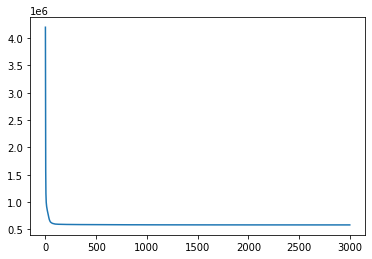

In [5]:
plt.plot(training_loss)

### Cross-validation

In [7]:
cvs = [1, 2, 3, 5, 6, 8]
batch_info = 500

config_names = [
    'th1_U-el-1_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-2_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-el-4_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
] + [
    'th1_U-eq-3_svgp-64_X[hd-omega-speed-x-y-time]_Z[]_40K11_0d0_10f{}'.format(cv) 
    for cv in cvs
]


Ell = []
for name in config_names:
    full_model, training_loss, fit_dict, val_dict = models.load_model(
        name,
        checkpoint_dir,
        dataset_dict,
        batch_info,
        device,
    )
    
    Ell.append(
        models.RG_pred_ll(
            full_model,
            val_dict,
            neuron_group=None,
            ll_mode="GH",
            ll_samples=100,
            cov_samples=1,
            beta=0.0,
        )
    )
    
Ell = np.array(Ell).reshape(-1, len(cvs))

<ErrorbarContainer object of 3 artists>

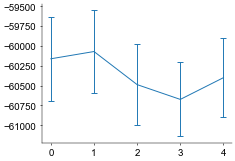

In [8]:
plt.errorbar(np.arange(Ell.shape[0]), Ell.mean(-1), yerr=Ell.std(-1) / np.sqrt(len(cvs)), capsize=3)